# Predicting the IMDb rating of Arrow (American TV Serie) through scripts
## From the site: https://subslikescript.com/ 
## by: Anna Luiza Gomes

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV # para o grid search
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler # para padronização
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline # para o pipeline

In [2]:
# configuração para não exibir os warnings

import warnings
warnings.filterwarnings("ignore")

# ignorando future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [3]:
scripts = pd.read_csv('Data/scripts.csv', sep=";")

In [4]:
scripts.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
scripts.head()

,nome_ep,Episodios,text_processed,0,1,2,nota_imdb,qtd_reviews,Topic
0,/series/Arrow-2193021/season-1/episode-1-Pilot,The name of the islandthey found me on is Lian...,the name of the islandthey found me on is lian...,0.017705,0.154588,0.827707,8.5,7572,2
1,/series/Arrow-2193021/season-1/episode-2-Honor...,[PANTING][GRUNTS][SPEAKING IN FOREIGN LANGUAGE...,[panting][grunts][speaking in foreign language...,0.991546,0.000000,0.000000,8.2,5731,0
2,/series/Arrow-2193021/season-1/episode-3-Lone_...,"My name is Oliver Queen.To my family, I am the...",my name is oliver queen to my family i am the...,0.049198,0.130277,0.820525,8.4,5367,2
3,/series/Arrow-2193021/season-1/episode-4-An_In...,"My name is Oliver Queen.For 5 years, I was str...",my name is oliver queen for 5 years i was str...,0.020276,0.084969,0.894755,8.3,5071,2
4,/series/Arrow-2193021/season-1/episode-5-Damaged,"OLIVER:My name is Oliver Queen.For five years,...",oliver:my name is oliver queen for five years ...,0.999916,0.000000,0.000000,8.6,5011,0


In [6]:
scripts.shape

(165, 9)

In [7]:
wiki = pd.read_csv('Data/wikipedia.csv', sep=";")

In [8]:
wiki.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
# the script is missing the episodes 12,13,14 from season 7 and episode 4 from season 3
# plus episode 18 from season 2 which is in portuguese
wiki.loc[[40,49,149,150,151]]  

,No.overall,No. inseason,Title,Directed by,Written by,Original air date,Prod.code,U.S. viewers(millions)
40,41,18,"""Deathstroke""",Guy Bee,Marc Guggenheim & Drew Z. Greenberg,"April 2, 2014",2J7468,2.32[49]
49,50,4,"""The Magician""",John Behring,Marc Guggenheim & Wendy Mericle,"October 29, 2014",3J5154,2.49[58]
149,150,12,"""Emerald Archer""",Glen Winter,Marc Guggenheim & Emilio Ortega Aldrich,"February 4, 2019",T27.13662,1.07[159]
150,151,13,"""Star City Slayer""",Gregory Smith,Beth Schwartz & Jill Blankenship,"February 11, 2019",T27.13663,1.09[160]
151,152,14,"""Brothers & Sisters""",Marcus Stokes,Rebecca Bellotto & Jeane Wong,"March 4, 2019",T27.13664,0.89[161]


In [10]:
wiki = wiki.drop(wiki.index[[40,49,149,150,151]]) #removing line 40

In [11]:
wiki = wiki.reset_index(drop=True)

In [12]:
wiki.shape

(165, 8)

In [13]:
dataset = pd.concat([wiki, scripts], axis=1) 

In [14]:
dataset.columns

Index(['No.overall', 'No. inseason', 'Title', 'Directed by', 'Written by',
       'Original air date', 'Prod.code', 'U.S. viewers(millions)', 'nome_ep',
       'Episodios', 'text_processed', '0', '1', '2', 'nota_imdb',
       'qtd_reviews', 'Topic'],
      dtype='object')

In [15]:
dataset[['viewers(millions)','residual']] = dataset['U.S. viewers(millions)'].str.split('[',expand=True)

In [16]:
dataset.drop(['U.S. viewers(millions)','residual','Title','text_processed','nome_ep','Topic','Episodios', 'No.overall', 'No. inseason', 'Written by', 'Prod.code', 'Original air date'], axis = 1 ,inplace = True)

In [17]:
dataset = dataset[[ 'Directed by', 'qtd_reviews', '0','1','2', 'viewers(millions)',  'nota_imdb']]

In [18]:
dataset.columns = ['Directed_by',  'qtd_reviews', '0','1','2','viewers(millions)',  'nota_imdb']

In [19]:
dataset.head()

,Directed_by,qtd_reviews,0,1,2,viewers(millions),nota_imdb
0,David Nutter,7572,0.017705,0.154588,0.827707,4.14,8.5
1,David Barrett,5731,0.991546,0.000000,0.000000,3.55,8.2
2,Guy Bee,5367,0.049198,0.130277,0.820525,3.51,8.4
3,Vince Misiano,5071,0.020276,0.084969,0.894755,3.05,8.3
4,Michael Schultz,5011,0.999916,0.000000,0.000000,3.75,8.6


In [36]:
dataset["viewers(millions)"] = pd.to_numeric(dataset["viewers(millions)"])

In [37]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Directed_by        165 non-null    float64
 1   qtd_reviews        165 non-null    int64  
 2   0                  165 non-null    float64
 3   1                  165 non-null    float64
 4   2                  165 non-null    float64
 5   viewers(millions)  165 non-null    float64
 6   nota_imdb          165 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 9.1 KB


## Splitting the dataset in test and train for clusterization

In [38]:
from sklearn.preprocessing import OrdinalEncoder

# definindo a transformação ordinal encoding
encoder = OrdinalEncoder()

# transformando os dados
dataset[["Directed_by"]] = encoder.fit_transform(dataset[["Directed_by"]])

In [39]:
dataset.head()

,Directed_by,qtd_reviews,0,1,2,viewers(millions),nota_imdb
0,9.0,7572,0.017705,0.154588,0.827707,4.14,8.5
1,7.0,5731,0.991546,0.000000,0.000000,3.55,8.2
2,18.0,5367,0.049198,0.130277,0.820525,3.51,8.4
3,49.0,5071,0.020276,0.084969,0.894755,3.05,8.3
4,40.0,5011,0.999916,0.000000,0.000000,3.75,8.6


In [49]:
# separando os atributos e a classe do dataset
array = dataset.values
X = array[:,0:6]
Y = array[:,6]

# definindo o tamanho do conjunto de teste
test_size = 0.20 

# A semente (seed) pode ser qualquer número, e garante que os resultados possam ser reproduzidos de forma idêntica toda vez que o script for rodado. 
# Isto é muito importante quando trabalhamos com modelos ou métodos que utilizam de algum tipo de aleatoriedade.
seed = 7

# particionando em conjuntos de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [41]:
X

array([[9.00000000e+00, 7.57200000e+03, 1.77050196e-02, 1.54588148e-01,
        8.27706814e-01, 4.14000000e+00],
       [7.00000000e+00, 5.73100000e+03, 9.91545856e-01, 0.00000000e+00,
        0.00000000e+00, 3.55000000e+00],
       [1.80000000e+01, 5.36700000e+03, 4.91979904e-02, 1.30277425e-01,
        8.20524573e-01, 3.51000000e+00],
       [4.90000000e+01, 5.07100000e+03, 2.02759691e-02, 8.49692672e-02,
        8.94754767e-01, 3.05000000e+00],
       [4.00000000e+01, 5.01100000e+03, 9.99916077e-01, 0.00000000e+00,
        0.00000000e+00, 3.75000000e+00],
       [2.40000000e+01, 4.74900000e+03, 1.71511352e-01, 1.61544442e-01,
        6.66944265e-01, 3.83000000e+00],
       [8.00000000e+00, 4.66400000e+03, 7.52991915e-01, 1.69246912e-01,
        7.77611732e-02, 3.74000000e+00],
       [2.80000000e+01, 4.53900000e+03, 5.49464710e-02, 6.69710279e-01,
        2.75343269e-01, 3.35000000e+00],
       [2.50000000e+01, 4.35300000e+03, 1.25238419e-01, 3.03274959e-01,
        5.71486652e-01, 

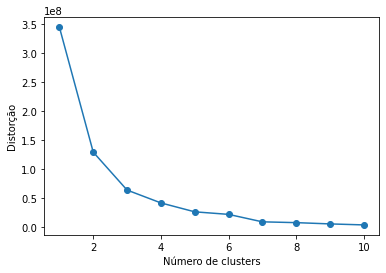

In [55]:
# Cria um array para armazenar os erros
distortions = []

# Cria modelos com k variando de 1 a 11, usando os mesmos parâmetros do modelo anterior
for i in range(1, 11):
    modelo = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    modelo.fit(X)
    distortions.append(modelo.inertia_) # inertia_ : Soma das distâncias quadráticas dos pontos ao centróide de cluster mais próximo.

# Configura e exibe o gráfico
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Distorção')
plt.show()

### Ideal number of clusters = 3

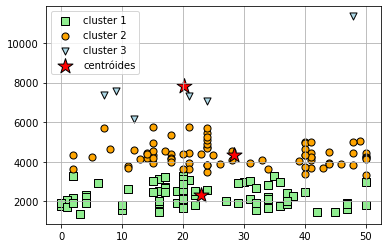

In [78]:
# Criação do modelo
modelo = KMeans(
    n_clusters=3,   # número de clusters
    init='random',  # método de inicializaçãp
    n_init=10,      # número de execuções com diferentes centróides aleatórios para escolher o modelo final
    max_iter=300,   # número máximo de iterações para cada execução única
    tol=1e-04,      # = 0,0001 - controla a tolerância com relação às alterações no erro quadrático dentro do cluster para declarar convergência
    random_state=0  # semente
)

# Predição dos clusters
y_km = modelo.fit_predict(X)

# Plotagem dos 3 clusters
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X[y_km == 2, 0], X[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# Plotagem dos centróides
plt.scatter(
    modelo.cluster_centers_[:, 0], modelo.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centróides'
)

# Legenda do gráfico
plt.legend(scatterpoints=1)

# Exibição do gráfico com clusters e centróides
plt.grid()
plt.show()